In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.stats import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
from jetstream_hugo.hotspells import *
from simpsom.plots import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

/storage/homefs/hb22g102/miniforge3/envs/env11_2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
exp_s = Experiment(
    "ERA5", "plev", "s", "6H", "all", "JJA", -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], None, None, None, reduce_da=True
)
da_s = exp_s.da

exp_pvs = Experiment("ERA5", "surf", "pvs", "6H", "all", "JJA", *exp_s.region, 250, "hourofyear", {"hourofyear": ("win", 4 * 15)}, None)
da_pvs = exp_pvs.da

exp_z = Experiment(
    "ERA5", "plev", "z", "6H", "all", "JJA", *exp_s.region, 500, 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None,
)
da_z = exp_z.da

exp_T = Experiment(
    "ERA5", "surf", "t", "6H", "all", "JJA", -30, 40, 30, 75, 250, 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None,
)
da_T = exp_T.da

exp_s10 = Experiment(
    "ERA5", "surf", "s10", "6H", "all", "JJA", -30, 40, 30, 75, 250, 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None,
)
da_s10 = exp_s10.da

exp_tp = Experiment(
    "ERA5", "surf", "tp", "6H", "all", "JJA", -30, 40, 30, 75, 250, 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None,
)
da_tp = exp_tp.da

In [3]:
n_clu = 22
Z = exp_T.heat_wave_linkage()
mask = get_land_mask()
lon, lat = da_T.lon.values, da_T.lat.values
mask = mask.sel(lon=lon, lat=lat)
stack_dims = {'lat_lon': ('lat', 'lon')}
mask_flat = mask.stack(stack_dims)
clusters = cut_tree(Z, n_clusters=n_clu)[:, 0]
clusters_da = np.zeros(mask_flat.shape, dtype=float)
clusters_da[:] = np.nan
clusters_da = mask_flat.copy(data=clusters_da)
clusters_da[mask_flat] = clusters
clusters_da = clusters_da.unstack()

In [6]:
metric = "euclidean"
nx = 6
ny = 4
net, centers, labels = exp_s.som_cluster(
    nx,
    ny,
    metric=metric,
    return_type=RAW_REALSPACE,
    force=False,
    train_kwargs=dict(train_algo="batch", epochs=50, start_learning_rate=0.05),
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
labels = xr.DataArray(labels, coords={"time": exp_s.samples_dims["time"]})
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_s.da.time, "cluster": np.arange(net.n_nodes)})

# Visualize clusters

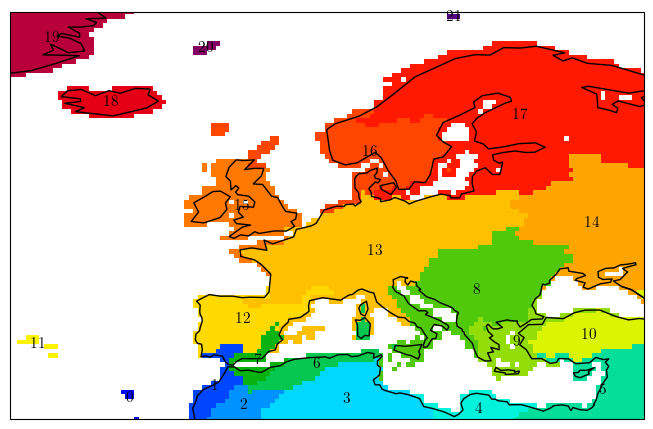

In [4]:
clu = Clusterplot(1, 1, exp_T.region)
cmap = colormaps.BlAqGrYeOrReVi200
ax = clu.axes[0]
unique_clusters = np.arange(n_clu)
norm = BoundaryNorm(np.concatenate([[-1], unique_clusters]) + 0.5, cmap.N)
clusters_da.plot(
    ax=ax,
    cmap=cmap,
    add_colorbar=False,
    add_labels=False
)
for j in range(n_clu):
    lo = clusters_da.lon.where(clusters_da==j).mean().item()
    la = clusters_da.lat.where(clusters_da==j).mean().item()
    ax.text(lo, la, f"${j}$", ha="center", va="center", fontweight="bold")

# Relative time series

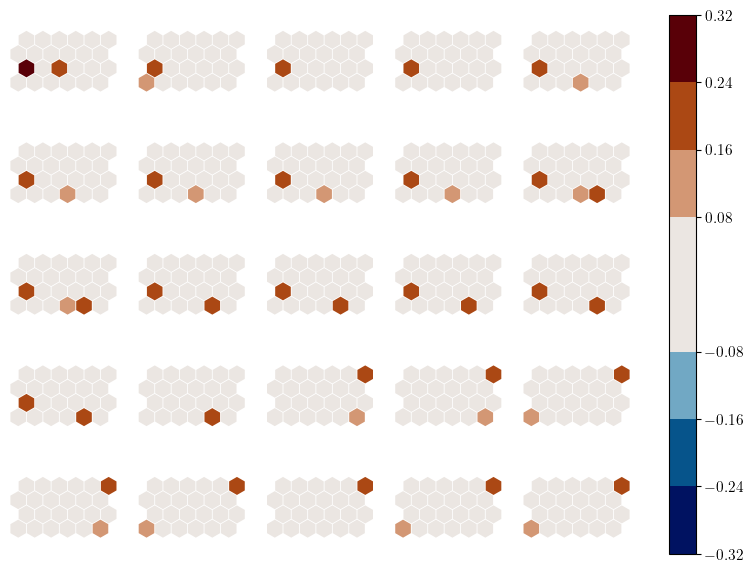

In [94]:
days_before = 3
da_cee = da_T.where(clusters_da == 13).mean(["lon", "lat"])
predictors = xr.DataArray(
    labels_to_mask(labels),
    coords={'time': labels.time.values, 'center': np.arange(net.n_nodes)}
)
predictors_masked = mask_from_t(
    da_cee, predictors.astype(float), q=.95,
    time_before=pd.Timedelta(days_before, 'D')
)
predictors_masked = predictors_masked.sel(time_around_beg=slice(pd.Timedelta(-24 * days_before, 'h'), pd.Timedelta(24 * days_before, 'h')))
# dt = (labels.time.values[1] - labels.time.values[0]).astype('timedelta64[h]')
# x = predictors_masked.time_around_beg.values.astype('timedelta64[h]')
# y = predictors_masked.center.values
freq_anoms = predictors_masked.mean(dim='heat_wave').values.T
freq_anoms = freq_anoms - predictors.mean(dim='time').values[:, None]

fig, axes = plt.subplots(5, 5, figsize=(10, 7), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.vik
levels = MaxNLocator(7, symmetric=True).tick_values(freq_anoms.min(), freq_anoms.max())
levels = np.delete(levels, len(levels) // 2)  
norm = BoundaryNorm(levels, cmap.N)        
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, spacing="proportional")
for ax, freq_anom in zip(axes.ravel(), freq_anoms.T):
    fig, ax = net.plot_on_map(
        freq_anom,
        fig=fig,
        ax=ax,
        cmap=cmap,
        norm=norm,
        draw_cbar=False,
    )                          
fig.set_tight_layout(False)

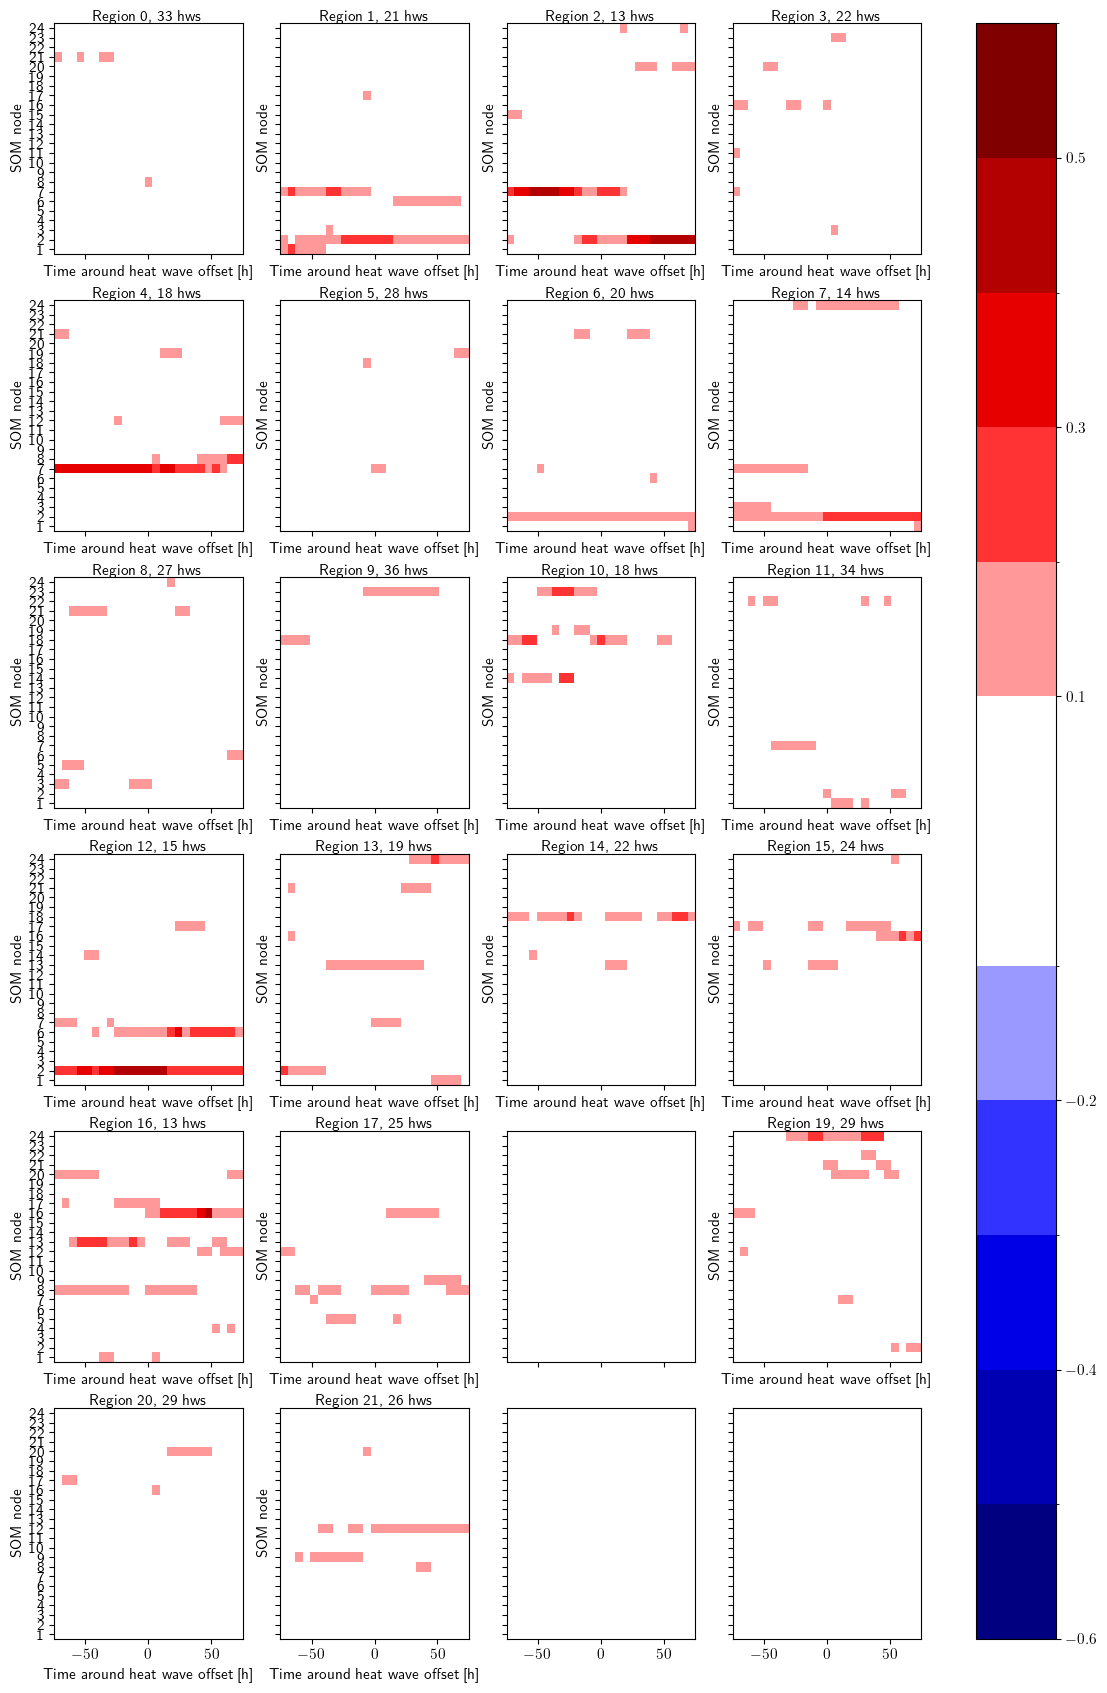

In [114]:
days_before = 3
fig, axes = plt.subplots(
    6, 4, figsize=(2 * TEXTWIDTH_IN, 3 * TEXTWIDTH_IN), tight_layout=False, sharex="all", sharey="all"
)
cmap = colormaps.BlWhRe
levels = np.arange(-0.6, 0.61, 0.1)
levels = np.delete(levels, len(levels) // 2)
norm = BoundaryNorm(levels, cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, spacing="proportional")
for n, ax in zip(range(n_clu), axes.ravel()):
    da_cee = da_T.where(clusters_da == n).mean(["lon", "lat"])
    predictors = xr.DataArray(
        labels_to_mask(labels),
        coords={"time": labels.time.values, "center": np.arange(net.n_nodes)},
    )
    try:
        predictors_masked = mask_from_t(
            da_cee,
            predictors.astype(float),
            q=0.9,
            minlen=pd.Timedelta(4, "D"),
            time_before=pd.Timedelta(days_before, "D"),
        )
    except ValueError:
        continue
    predictors_masked = predictors_masked.sel(
        time_around_beg=slice(
            pd.Timedelta(-24 * days_before, "h"), pd.Timedelta(24 * days_before, "h")
        )
    )
    dt = (labels.time.values[1] - labels.time.values[0]).astype("timedelta64[h]")
    x = predictors_masked.time_around_beg.values.astype("timedelta64[h]")
    y = predictors_masked.center.values
    freq_anoms = predictors_masked.mean(dim="heat_wave").values.T
    freq_anoms = freq_anoms - predictors.mean(dim="time").values[:, None]

    ax.pcolormesh(
        x.astype(int),
        y,
        freq_anoms,
        shading="nearest",
        cmap=cmap,
        norm=BoundaryNorm(levels, cmap.N),
    )
    ax.set_xlabel("Time around heat wave offset [h]")
    ax.set_ylabel("SOM node")
    ax.set_yticks(np.arange(net.n_nodes), labels=np.arange(1, net.n_nodes + 1))
    ax.set_title(f"Region {n}, {len(predictors_masked.heat_wave)} hws")
fig.set_tight_layout(False)

# Overall at onset

In [55]:
def get_frequency_anomaly(hs_da: xr.DataArray, labels: xr.DataArray | NDArray, year: int | Sequence = YEARS, len_thresh: int = 1): 
    if isinstance(year, int):
        year = [year]
    mask = labels_to_mask(labels)
    mask_thisyear = labels.time.dt.year.isin(year)
    unique_labels, counts = np.unique(labels.sel(time=mask_thisyear), return_counts=True)
    thisyear_pops = np.zeros(mask.shape[1], dtype=int)
    thisyear_pops[unique_labels[1:] - 1] = counts[1:]
    thisyear_probas = thisyear_pops / np.sum(thisyear_pops)
    hs_da = hs_da.sel(time=mask_thisyear)
    conditional_probas = (
        np.sum(
            (hs_da > len_thresh).values[:, None] & mask[mask_thisyear.values], axis=0
        )
        / np.sum((hs_da > len_thresh).values, axis=0)
    )
    return conditional_probas - thisyear_probas[:]

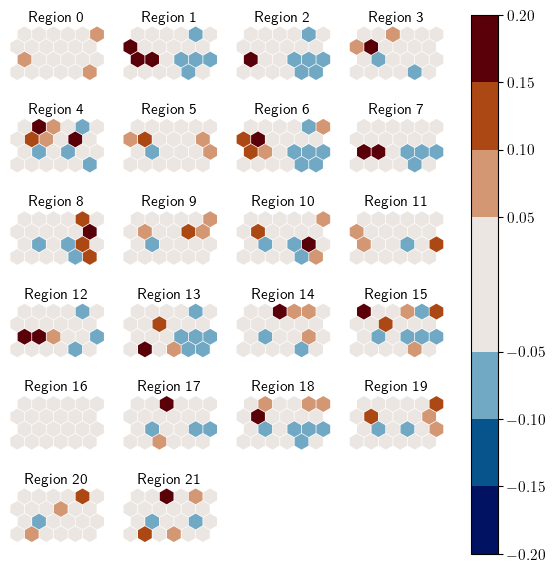

In [115]:
fig, axes = plt.subplots(6, 4, figsize=(TEXTWIDTH_IN, 7.), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.vik
levels = np.arange(-0.2, 0.23, 0.05)
levels = np.delete(levels, len(levels) // 2)
norm = BoundaryNorm(levels, cmap.N)
fig.colorbar(ScalarMappable(norm, cmap), ax=axes, spacing="proportional")
for n, ax in zip(range(n_clu), axes.ravel()):
    da_cee = da_T.where(clusters_da == n).mean(["lon", "lat"])
    try:
        heat_waves_ts, heat_waves, hs_da = heat_waves_from_t(
            da_cee, q=0.95, minlen=np.timedelta64(4, "D"), output_type="both"
        )
        to_plot = get_frequency_anomaly(hs_da, labels)
    except ValueError:
        to_plot = np.zeros(net.n_nodes)
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        draw_cbar=False,
        fig=fig,
        ax=ax,
        cmap=cmap,
        norm=norm,
    )
    ax.set_title(f"Region {n}")
for ax in axes.ravel()[n_clu:]:
    ax.set_visible(False)
fig.set_tight_layout(False)

## Events basis

In [124]:
# season = da_cee.sel(time=(da_cee.time.dt.year == 2018) & (da_cee.time.dt.month == 7)).time.values
da_cee = da_T.where(clusters_da == 13).mean(["lon", "lat"])
da_cee = xrft.detrend(da_cee, "time", "linear")
heat_waves_ts, heat_waves, hs_da = heat_waves_from_t(
    da_cee, q=0.9, minlen=np.timedelta64(3, "D"), output_type="both"
)
heat_wave = heat_waves_ts[-2]
labels.attrs["width"] = net.width
labels.attrs["height"] = net.height
labels.attrs["n_nodes"] = net.n_nodes
fig, ax, cbar = plt_traj_hotspell(heat_wave, labels, da_cee)
# fig.savefig(f'{FIGURES}/som_props/hotspell_2022.png', dpi=300, bbox_inches='tight')

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


: 

# Max. residence time comparison

In [86]:
da_cee = da_T.where(clusters_da == 17).mean(["lon", "lat"])
heat_waves_ts, heat_waves, hs_da = heat_waves_from_t(
    da_cee, q=0.95, minlen=np.timedelta64(4, "D"), output_type="both"
)
heat_waves_stays = {'longest_stay': [], 'ref_distrib': [], 'significant': []}
for heat_wave in heat_waves_ts:
    len_ = len(heat_wave)
    start_month = heat_wave[0].month
    start_times = np.where(labels.time.dt.month==start_month)[0]
    indices = start_times[:, None] + np.arange(len_)[None, :]
    from scipy.stats import mode
    try:
        these_bmus = labels.values[indices]
    except IndexError:
        continue
    counts = mode(np.cumsum(np.diff(these_bmus, axis=1) != 0, axis=1), axis=1)[1]
    these_bmus = labels.loc[heat_wave].values
    heat_wave_longest_stay = mode(np.cumsum(np.diff(these_bmus) != 0))[1]
    print(np.quantile(counts, 0.95), heat_wave_longest_stay)
    heat_waves_stays['longest_stay'].append(heat_wave_longest_stay)
    heat_waves_stays['ref_distrib'].append(np.sort(counts))
    heat_waves_stays['significant'].append(heat_wave_longest_stay >= np.quantile(counts, 0.9))
np.where(heat_waves_stays['significant'])[0]

32.0 14
17.0 15
19.0 9
21.0 8
16.0 8
18.0 10


array([], dtype=int64)

# More or less jumps ?

In [72]:
da_cee.resample(time='1Y').mean().values

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


array([-0.257, -0.382, -0.375, -0.171, -0.248,  0.002,  0.164,  0.304,
       -0.435, -0.248,  0.035, -0.226, -0.307,  0.1  , -0.234, -0.127,
       -0.677, -0.315, -0.386, -0.129,  0.022, -0.106, -0.704, -0.21 ,
       -0.406, -0.785, -0.429, -0.25 , -0.581, -0.424, -0.283, -0.518,
       -0.33 , -0.274, -0.489, -0.287, -0.57 , -0.722, -0.853, -0.462,
       -0.388, -0.345, -0.464, -0.248, -0.404, -0.352, -0.419, -0.424,
        0.083,  0.09 ,  0.051, -0.113, -0.169, -0.524,  0.015,  0.152,
       -0.304,  0.111,  0.203,  0.549,  0.122,  0.445,  0.621,  0.913,
        0.361,  0.477,  0.803,  0.464,  0.391,  0.562,  0.806,  0.556,
        0.588,  0.72 ,  0.806,  0.522,  1.017,  0.705,  1.155,  0.754,
        0.736,  0.922,  1.1  ], dtype=float32)

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


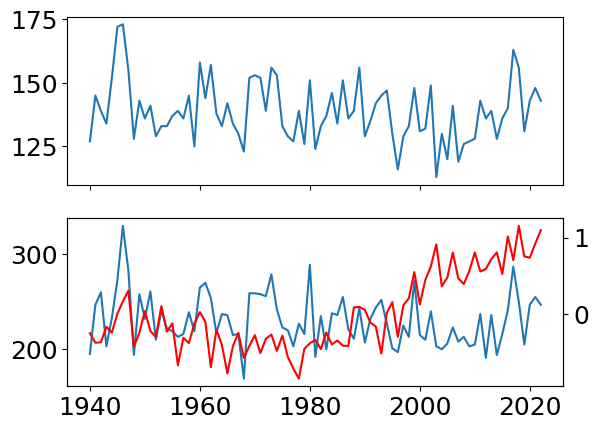

In [77]:
dist_mat = net.neighborhoods.distances
years = np.unique(labels.time.dt.year.values)
jumps_per_year = []
distance_per_year = []
for year in years:
    nodes = labels.sel(time=labels.time.dt.year == year).values
    jumps = np.diag(dist_mat[nodes[:-1], :][:, nodes[1:]])
    jumps_per_year.append(np.sum(jumps > 0))
    distance_per_year.append(np.sum(jumps))
fig, axes = plt.subplots(2, 1, sharex='all')
axes[0].plot(years, jumps_per_year)
axes[1].plot(years, distance_per_year)
axes[1].twinx().plot(years, da_cee.resample(time='1Y').mean().values, color='red')

In [8]:
jumps = bmus_da[:-1].copy(data=dist_mat[bmus_da[:-1], bmus_da[1:]])

In [ ]:
heat_waves_jumps = {'distance': [], 'ref_distrib': [], 'significative': []}
for heat_wave in heat_waves_ts:
    len_ = len(heat_wave)
    start_month = heat_wave[0].month
    start_times = np.where(bmus_da.time.dt.month==start_month)[0]
    indices = start_times[:, None] + np.arange(len_)[None, :]
    ref_distrib = np.sum(jumps.values[indices], axis=1)
    compare_against = np.quantile(ref_distrib, q=0.01)
    heat_wave_distance = np.sum(jumps.loc[heat_wave].values)
    heat_waves_jumps['distance'].append(heat_wave_distance)
    heat_waves_jumps['ref_distrib'].append(np.sort(ref_distrib))
    heat_waves_jumps['significative'].append(heat_wave_distance <= compare_against)
np.where(heat_waves_jumps['significative'])[0]

array([31])

In [ ]:
yearbreaks = np.sum(bmus_da.time.dt.year == bmus_da.time.dt.year[0]).item()
possible_tuples = [
    (i, j) for i, j in product(range(net.n_nodes), range(net.n_nodes))
]
possible_tuples = np.asarray(possible_tuples, dtype='i,i')
indices = [i for n in range(len(np.unique(bmus_da.time.dt.year))) for i in range(n * yearbreaks, (n + 1) * yearbreaks - 1)]
transitions = np.zeros(len(da_s.time), dtype='i, i')
transitions[indices] = [(net.bmus[i], net.bmus[i + 1]) for i in indices]
transition_masks = transitions[:, None] == possible_tuples[None, :]
unique_transitions, counts = np.unique(transitions, return_counts=True)
trans_mat = np.zeros((net.n_nodes, net.n_nodes))
trans_mat[unique_transitions['f0'], unique_transitions['f1']] = counts
sort_order = np.argsort(counts)[::-1][:50]
sort_order_1 = [i for i in sort_order if unique_transitions[i][0] == unique_transitions[i][1]]
sort_order_2 = [i for i in sort_order if unique_transitions[i][0] != unique_transitions[i][1]]

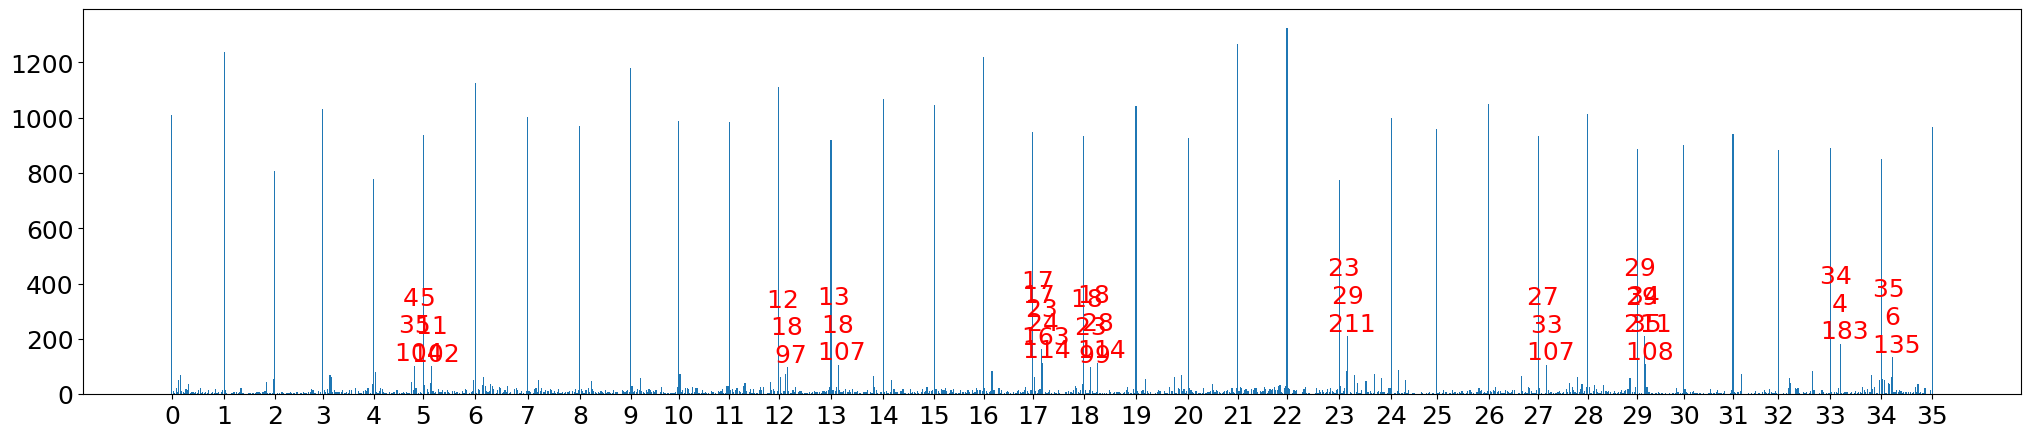

In [ ]:
fig, ax = plt.subplots(figsize=(25, 5))
ax.bar(np.arange(len(counts)), counts)
ax.set_xticks(sort_order_1, unique_transitions['f0'][sort_order_1])
for i in sort_order_2:
    xy = (i, counts[i])
    xytext = (i, counts[i])
    plt.annotate(f'{unique_transitions[i][0]} \n {unique_transitions[i][1]} \n {counts[i]}', xy=xy, xytext=xytext, ha='center', va='bottom', color='red')

In [ ]:
unique_transitions_heat_waves, counts_heat_waves = np.unique(transitions[np.where(np.isin(bmus_da.time.values, np.concatenate(heat_waves_ts)))[0]], return_counts=True)

In [ ]:
all_to_hs = np.isin(unique_transitions, unique_transitions_heat_waves)
counts_heat_waves - counts[all_to_hs]
# counts_heat_waves

array([ -984,   -51,   -67,   -14,   -37,    -6,   -19,    -6,    -3,
        -988,   -67,   -60,   -15,    -8,    -5,   -15,   -12,   -15,
         -22,  -775,    -9,   -11,    -5,  -929,   -31,  -101,   -12,
         -17,   -13,   -10,   -50, -1071,   -30,   -59,   -28,   -10,
          -7,   -11,   -29,   -17,   -13,    -6,   -18,   -22,   -13,
         -12,  -987,    -8,    -4,   -11,   -19,   -19,  -963,   -10,
         -16, -1129,   -28,   -57,   -11,   -12,   -12,  -957,   -16,
         -26,    -9,   -21,   -22,    -9,   -16,   -27,  -963,   -19,
         -14,   -22,   -27,    -3,   -17,    -5,   -16,   -25,   -42,
         -12, -1071,   -59,    -5,   -10,   -73,   -91,   -25,    -6,
          -5,   -15,   -24,  -905,  -102,   -16,    -9,    -7,    -6,
         -63,    -7, -1046,    -4,   -49,    -6,   -10,   -12,   -13,
       -1030,   -16,   -15,   -17,    -8,    -6,    -5,   -20,   -14,
       -1175,   -19,   -12,   -13,    -3,    -7,    -9,   -23,    -3,
         -11,  -910,

In [13]:
bmus_da.to_netcdf('/storage/homefs/hb22g102/persistent-extremes-era5/results/bmus_da.nc')
np.save('/storage/homefs/hb22g102/persistent-extremes-era5/results/heat_waves_cee.npy', heat_waves)

# Whole period, attribution and conditional probas

In [92]:
time_before = pd.Timedelta(3, "D")
da_cee = da_T.where(clusters_da == 17).mean(["lon", "lat"])
heat_waves_ts, heat_waves, hs_da = heat_waves_from_t(
    da_cee, q=0.95, minlen=np.timedelta64(3, "D"), time_before=time_before, output_type="both"
)
dt = heat_waves_ts[0][1] - heat_waves_ts[0][0]
nind = int(2 * time_before / dt)
clustered_hotspells = [[] for _ in range(net.n_nodes)]
for j, heat_wave in enumerate(heat_waves_ts):
    unique, counts = np.unique(labels.loc[heat_wave[:nind]], return_counts=True)
    where = np.argmax(counts)
    clustered_hotspells[int(unique[where])].append((len(heat_wave), j, counts[where]))

In [93]:
len(heat_waves_ts)

13

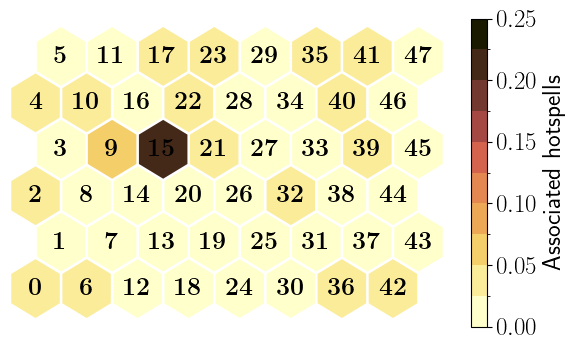

In [38]:
to_plot = np.asarray([len(cluhs) for cluhs in clustered_hotspells]) / len(heat_waves)
cmap = colormaps.lajolla
kwargs = {
    "cmap": cmap,
    "norm": BoundaryNorm(np.arange(0, 0.275, 0.025), cmap.N)
}
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
fig, ax = net.plot_on_map(
    to_plot,
    smooth_sigma=0,
    fig=fig,
    ax=ax,
    draw_cbar=False,
    **kwargs,
)
im = ScalarMappable(**kwargs)
fig.colorbar(im, ax=ax, label="Associated hotspells")
for i, c in enumerate(coords):
    x, y = c
    ax.text(x, y, r"$\mathbf{" + f"{i}" + r"}$", va="center", ha="center", color="Black")
plt.show()

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


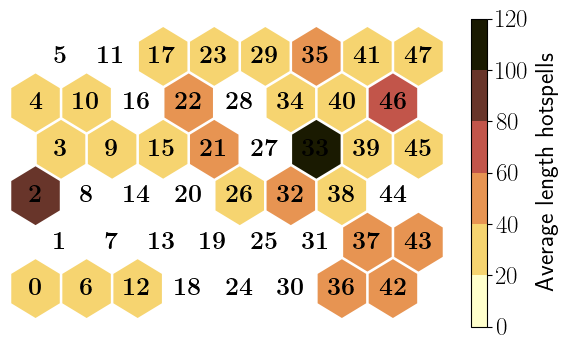

In [39]:
to_plot = np.asarray([np.mean([hs[0] for hs in cluhs]) for cluhs in clustered_hotspells])
cmap = colormaps.lajolla
kwargs = {
    "cmap": cmap,
    "norm": BoundaryNorm(np.arange(0, 140, 20), cmap.N)
}
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
fig, ax = net.plot_on_map(
    to_plot,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=ax,
    draw_cbar=False,
    **kwargs,
)
im = ScalarMappable(**kwargs)
fig.colorbar(im, ax=ax, label="Average length hotspells")
for i, c in enumerate(coords):
    x, y = c
    ax.text(x, y, r"$\mathbf{" + f"{i}" + r"}$", va="center", ha="center", color="Black")
plt.show()


/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


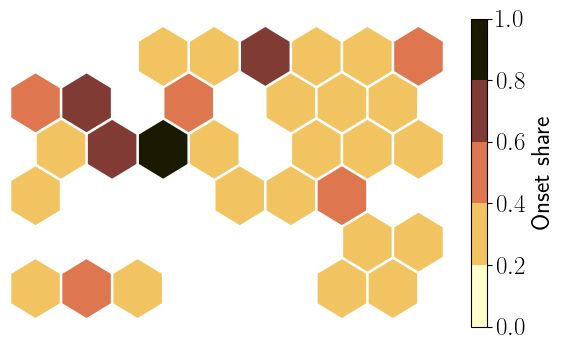

In [31]:
to_plot = np.asarray([np.mean([hs[2] / 24 for hs in cluhs]) for cluhs in clustered_hotspells])
cmap = colormaps.lajolla
kwargs = {
    "cmap": cmap,
    "norm": BoundaryNorm(np.arange(0, 1.2, .2), cmap.N)
}
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
fig, ax = net.plot_on_map(
    to_plot,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=ax,
    draw_cbar=False,
    **kwargs,
)
im = ScalarMappable(**kwargs)
fig.colorbar(im, ax=ax, label="Onset share")
plt.show()
